In [1]:
import pandas as pd
df_train = pd.read_csv("data/technical/sales_train.csv")


Imported AutoViz_Class version: 0.0.81. Call using:
    from autoviz.AutoViz_Class import AutoViz_Class
    AV = AutoViz_Class()
    AV.AutoViz(filename, sep=',', depVar='', dfte=None, header=0, verbose=0,
                            lowess=False,chart_format='svg',max_rows_analyzed=150000,max_cols_analyzed=30)
Note: verbose=0 or 1 generates charts and displays them in your local Jupyter notebook.
      verbose=2 saves plots in your local machine under AutoViz_Plots directory and does not display charts.
Shape of your Data Set: (2935849, 6)
############## C L A S S I F Y I N G  V A R I A B L E S  ####################
Classifying variables in data set...
    Number of Numeric Columns =  1
    Number of Integer-Categorical Columns =  3
    Number of String-Categorical Columns =  0
    Number of Factor-Categorical Columns =  0
    Number of String-Boolean Columns =  0
    Number of Numeric-Boolean Columns =  0
    Number of Discrete String Columns =  1
    Number of NLP String Columns =  

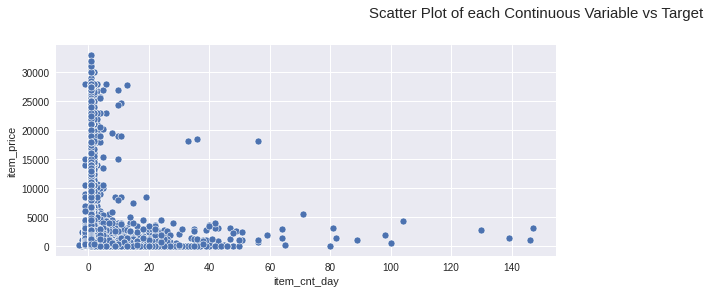

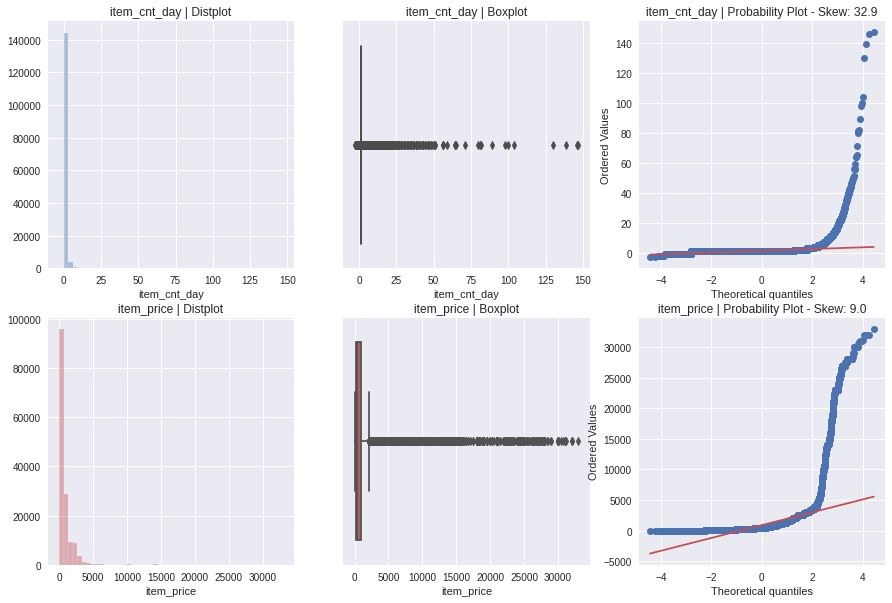

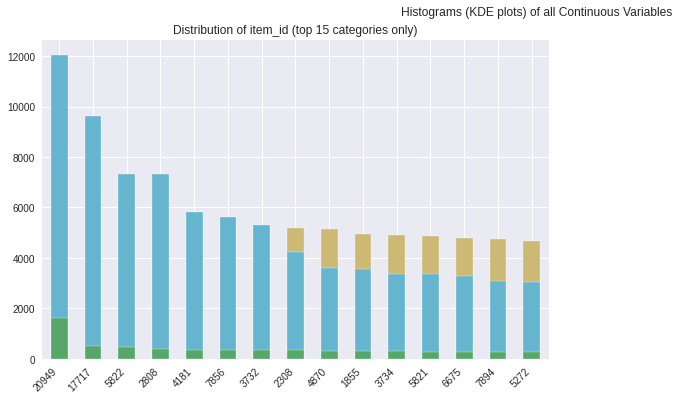

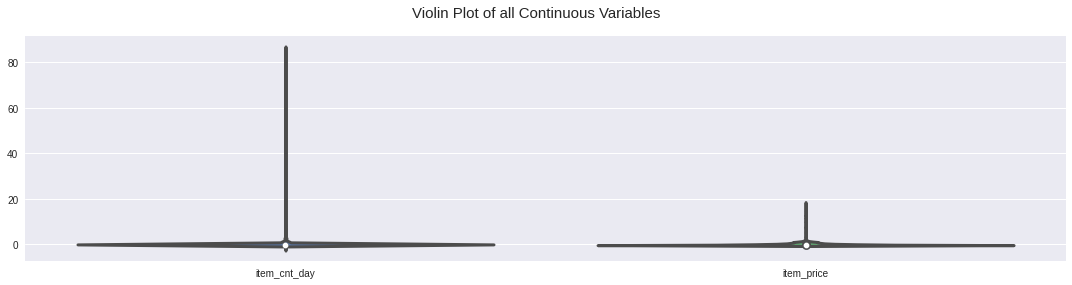

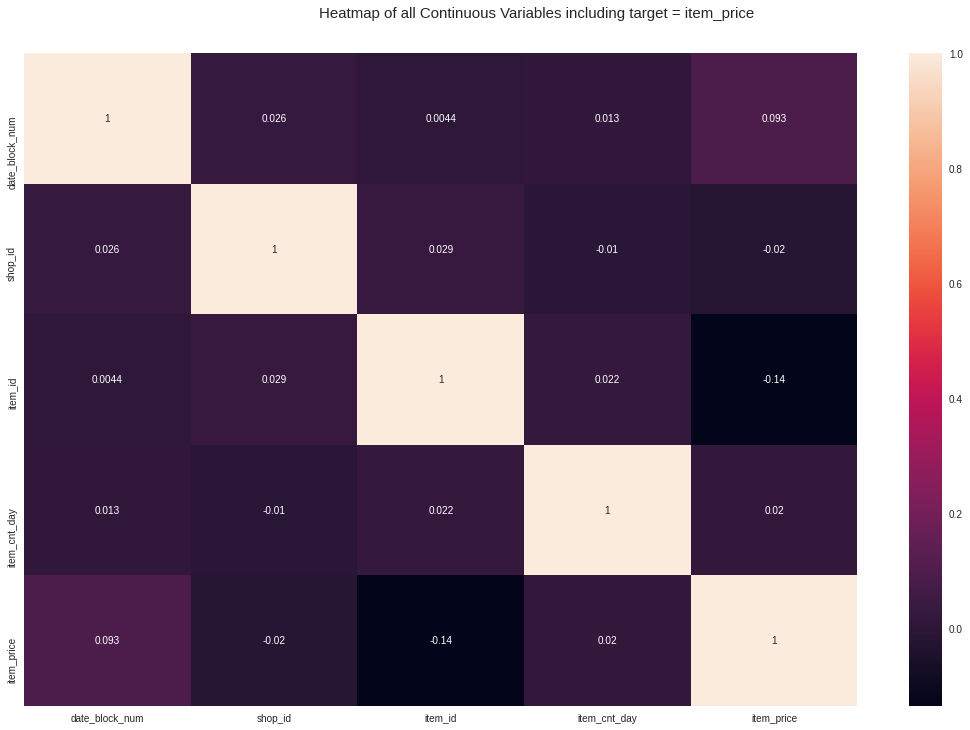

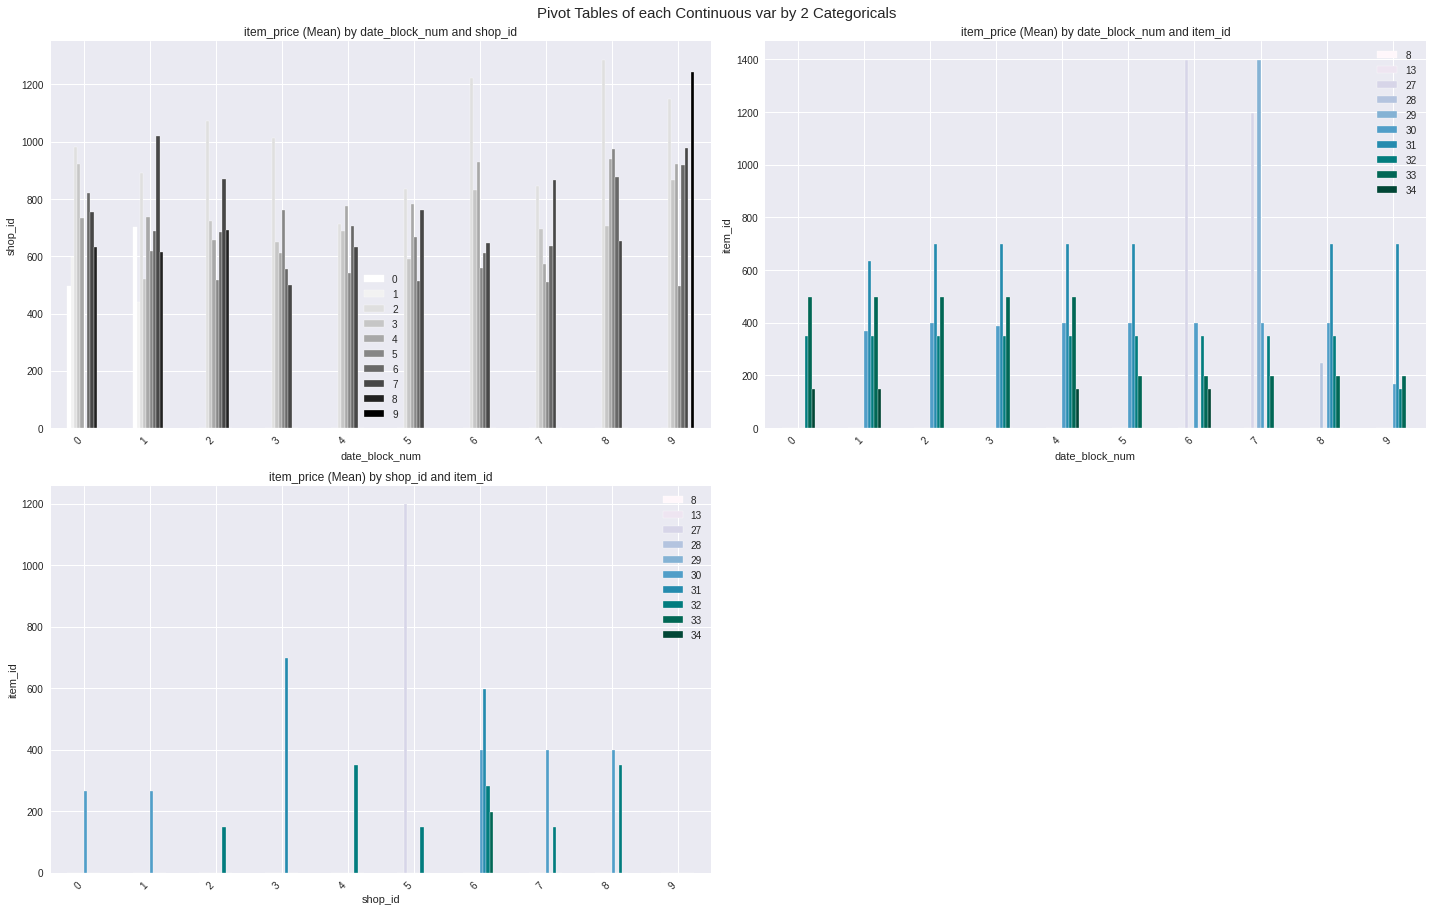

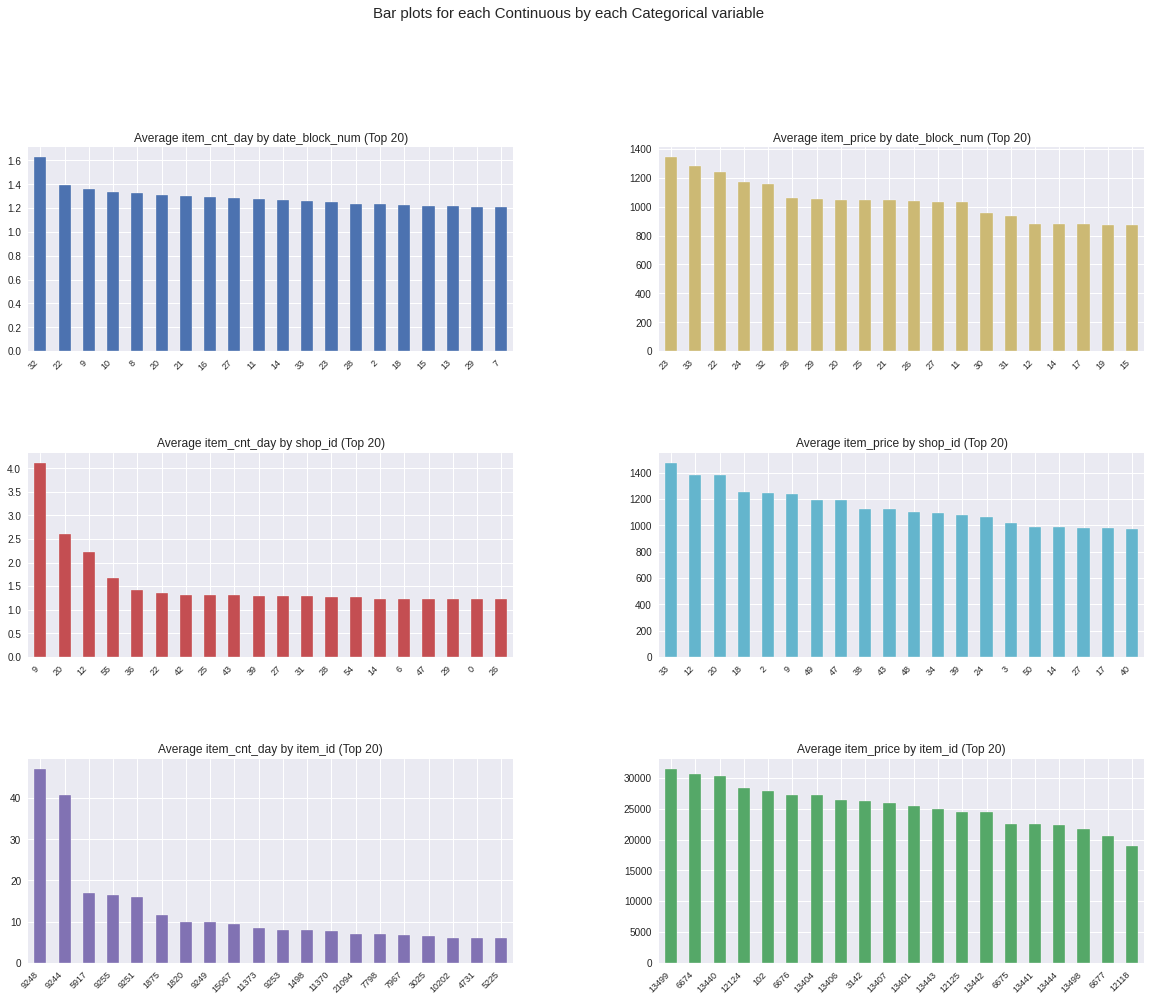

All Plots done
Time to run AutoViz (in seconds) = 6.462

 ###################### VISUALIZATION Completed ########################


In [2]:
# https://www.kaggle.com/yasserhessein/predict-future-sales-using-4-algorithms-regression

from autoviz.AutoViz_Class import AutoViz_Class
AV = AutoViz_Class()
target='item_price'
df = AV.AutoViz(filename="",sep=',', depVar=target, dfte=df_train, header=0, verbose=1,
                lowess=False, chart_format='svg', max_rows_analyzed=150000, max_cols_analyzed=30)